In [8]:
%load_ext autoreload
%autoreload 1
%aimport pycabnn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pycabnn as cbn

from scipy.spatial import KDTree
from scipy.spatial.distance import pdist
from scipy.optimize import curve_fit

import dask.dataframe as dd
from tqdm.dask import TqdmCallback
from dask.diagnostics import ProgressBar

from tqdm.autonotebook import tqdm, trange

In [10]:
from pycabnn.util import HocParameterParser

h = HocParameterParser()
config_hoc = str("../test_data/params/Parameters.hoc")
h.load_file(config_hoc)


In [11]:
mlipop = cbn.create_population("MLI", h)
mlipop.load_somata("../../big_test_data/MLIcoordinates.dat")
mlipop.add_dendrites()

Successfully read ../../big_test_data/MLIcoordinates.dat.


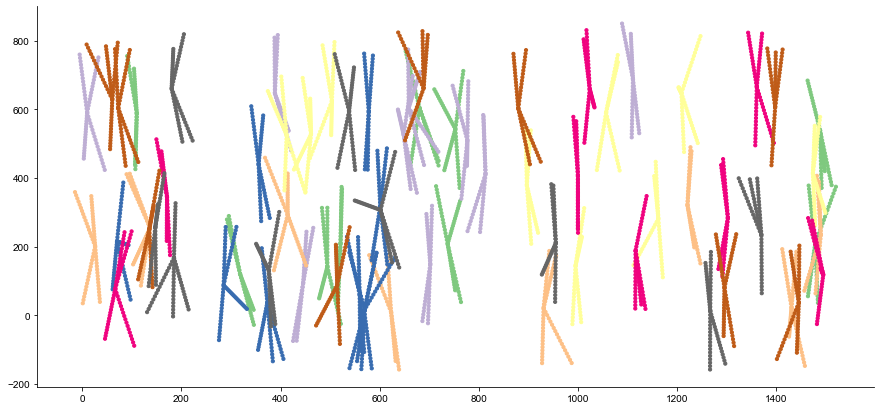

In [12]:
ncell = 70
nidx = ncell*90*4

_, ax = plt.subplots(figsize=(15,7))
ax.scatter(
    mlipop.dends.coo[:nidx:5,0],
    mlipop.dends.coo[:nidx:5,1], 
    10, 
    mlipop.dends.idx[:nidx:5], 
    cmap='Accent'
)

In [7]:
dend_coo = np.reshape(mlipop.dends.coo, (-1, 4, 90, 3))
som = mlipop.som

In [9]:
def compute_soma_dist(som):
    temp1 = pdist(som[:,[1, 2]])
    temp2 = pdist(som[:, 0][:, np.newaxis])
    som_dist = pd.DataFrame(np.zeros((temp1.shape[0], 2), dtype=int), columns=['i', 'j'])
    ifirst = 0
    ilast = som.shape[0]-1
    for i in trange(som.shape[0]-1):
        som_dist.iloc[ifirst:ilast, 0] = i
        som_dist.iloc[ifirst:ilast, 1] = np.arange(i+1, som.shape[0], dtype=int)
        ifirst = ilast
        ilast = ifirst + som.shape[0]-(i+2)
        
    som_dist['dist_xy'] = temp1
    som_dist['dist_z'] = temp2
    return som_dist

som_dist = compute_soma_dist(mlipop.som)

som_dist = som_dist[som_dist['dist_xy'] < 180]
som_dist = som_dist[som_dist['dist_z'] < 50]

  0%|          | 0/19723 [00:00<?, ?it/s]

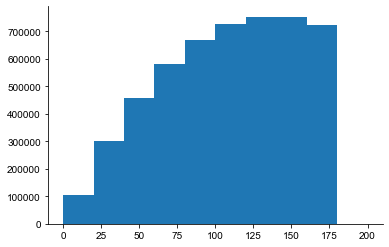

In [10]:
_ = plt.hist(som_dist['dist_xy'], bins=np.arange(0, 220, 20))

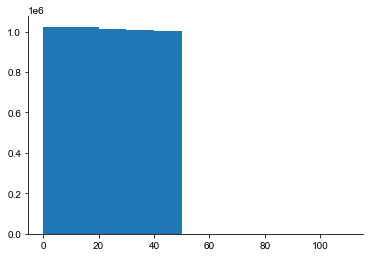

In [11]:
_ = plt.hist(som_dist['dist_z'], bins=np.arange(0, 120, 10))

In [12]:
dend_coo = np.reshape(mlipop.dends.coo, (som.shape[0], -1, 3))

def compute_dend_dist(input_pairs):
    def _min_dend_dist(i, j):
        dend1 = dend_coo[int(i),:,:]
        dend2 = dend_coo[int(j),:,:]
        tree1 = KDTree(dend1)
        z, _ = tree1.query(dend2, k=1)
        return z.min()
    
    zs = []
    for i in range(input_pairs.shape[0]):
        r = input_pairs.iloc[i]
        zs.append(_min_dend_dist(r.i, r.j))
    return zs


In [14]:
selected_pairs = som_dist[som_dist['dist_xy'] < 5]
# selected_pairs = som_dist
selected_pairs = selected_pairs.assign(dend_dist=compute_dend_dist(selected_pairs))
selected_pairs

,i,j,dist_xy,dist_z,dend_dist
36766,1,17045,2.424599,13.165548,3.911837
86057,4,7176,4.362915,12.118877,10.082214
112556,5,13957,4.019700,29.597594,29.014383
163384,8,5637,4.558460,25.982423,10.163423
205958,10,8784,4.141489,34.341725,30.976937
...,...,...,...,...,...
194378007,19213,19300,3.389811,48.528443,39.202964
194396231,19250,19357,3.205916,44.370415,26.050138
194402327,19263,19395,3.088513,30.215036,11.958226
194432314,19333,19667,0.420736,23.275729,11.434954


In [15]:
def _f(df):
    ddata = dd.from_pandas(df, npartitions=15)
    res = ddata.map_partitions(lambda df: df.assign(dend_dist=compute_dend_dist(df)))
    with ProgressBar():
        s1 = res.compute()  # compute the result
    return s1

In [21]:
selected_pairs = som_dist[som_dist['dist_xy'] < 20]
# selected_pairs = som_dist
selected_pairs = _f(selected_pairs)

[########################################] | 100% Completed | 33.2s


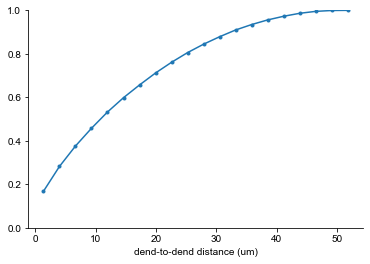

In [22]:
n, x = np.histogram(selected_pairs.dend_dist,20)
xc = (x[1:] + x[:-1]) / 2

_, ax = plt.subplots()

ax.plot(xc, np.cumsum(n)/n.sum(), '.-')
_ = ax.set(
    xlabel='dend-to-dend distance (um)',
    ylim=(0, 1),
)


In [ ]:
_, ax = plt.subplots()

ax.scatter(selected_pairs.dist_xy, selected_pairs.dend_dist, 1, selected_pairs.dist_z, alpha=0.1)

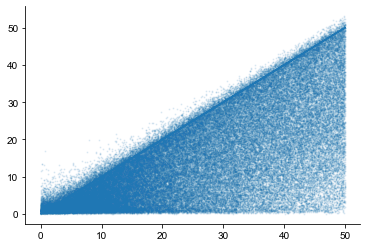

In [35]:
_, ax = plt.subplots()

ax.scatter(selected_pairs.dist_z, selected_pairs.dend_dist, 1, alpha=0.1)
ax.plot(selected_pairs.dist_z, selected_pairs.dist_z, '-r')

In [36]:
selected_pairs = som_dist[(som_dist['dist_xy'] >= 20) & (som_dist['dist_xy'] < 40)]
selected_pairs = _f(selected_pairs)

[########################################] | 100% Completed |  1min 31.1s


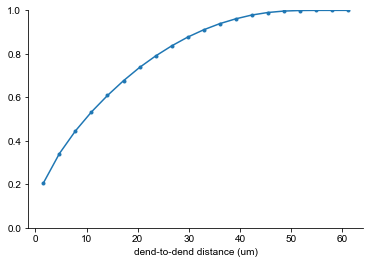

In [37]:
n, x = np.histogram(selected_pairs.dend_dist,20)
xc = (x[1:] + x[:-1]) / 2

_, ax = plt.subplots()

ax.plot(xc, np.cumsum(n)/n.sum(), '.-')
_ = ax.set(
    xlabel='dend-to-dend distance (um)',
    ylim=(0, 1),
)


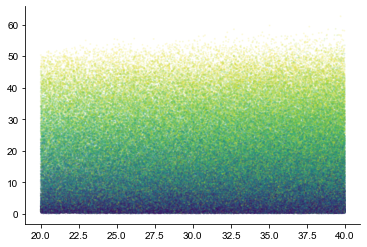

In [45]:
_, ax = plt.subplots()

ax.scatter(
    selected_pairs.dist_xy, 
    selected_pairs.dend_dist, 1, 
    selected_pairs.dist_z, 
    alpha=0.1
)

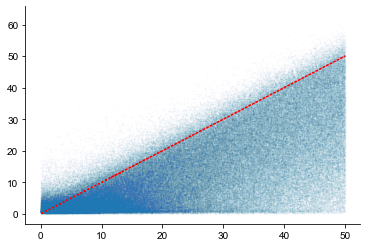

In [43]:
_, ax = plt.subplots()

ax.scatter(selected_pairs.dist_z, selected_pairs.dend_dist, 1, alpha=0.02)
ax.plot(selected_pairs.dist_z, selected_pairs.dist_z, ':r')

[########################################] | 100% Completed |  2min 25.9s


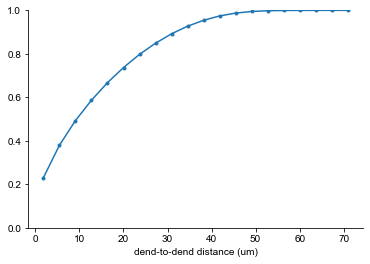

In [46]:
selected_pairs = som_dist[(som_dist['dist_xy'] >= 40) & (som_dist['dist_xy'] < 60)]
selected_pairs = _f(selected_pairs)

n, x = np.histogram(selected_pairs.dend_dist,20)
xc = (x[1:] + x[:-1]) / 2

_, ax = plt.subplots()

ax.plot(xc, np.cumsum(n)/n.sum(), '.-')
_ = ax.set(
    xlabel='dend-to-dend distance (um)',
    ylim=(0, 1),
)

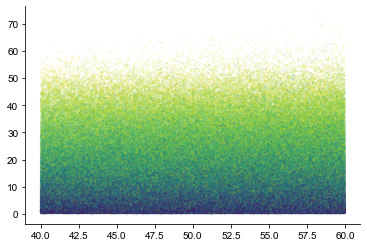

In [47]:
_, ax = plt.subplots()

ax.scatter(
    selected_pairs.dist_xy, 
    selected_pairs.dend_dist, 1, 
    selected_pairs.dist_z, 
    alpha=0.1
)

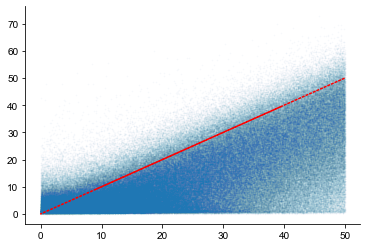

In [48]:
_, ax = plt.subplots()

ax.scatter(selected_pairs.dist_z, selected_pairs.dend_dist, 1, alpha=0.02)
ax.plot(selected_pairs.dist_z, selected_pairs.dist_z, ':r')

## Distance vs connectivity data

In [14]:
p_dist_xy = np.loadtxt('p_dist_xy.csv', delimiter=',')

(0.0, 200.0)

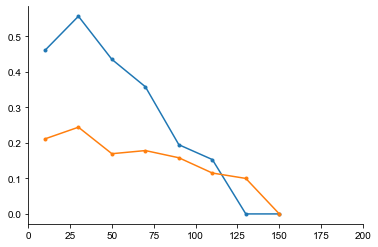

In [21]:
plt.plot(p_dist_xy[:,0], (p_dist_xy[:,1:]),'.-')
plt.xlim([0, 200])

In [16]:
p_dist_z = np.loadtxt('p_dist_z.csv', delimiter=',')
p_dist_z

array([[ 5.        ,  0.53939394,  0.19878788],
       [15.        ,  0.32242424,  0.21333333],
       [25.        ,  0.0569697 ,  0.17212121],
       [35.        ,  0.        ,  0.05818182],
       [45.        ,  0.        ,  0.        ]])

(0.0, 100.0)

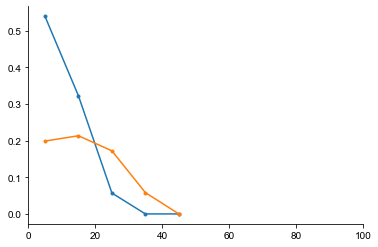

In [24]:
plt.plot(p_dist_z[:,0], p_dist_z[:,1:],'.-')
plt.xlim([0, 100])


In [73]:
nxy, c = np.histogram(som_dist['dist_xy'], bins=np.arange(0, 180, 20))
(c[:-1] + c[1:])/2

array([ 10.,  30.,  50.,  70.,  90., 110., 130., 150.])

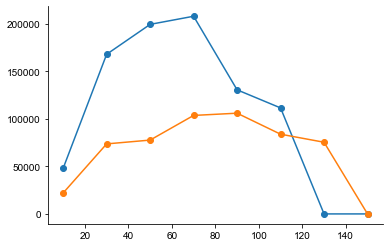

In [112]:
plt.plot(p_dist_xy[:,0], nxy[:,np.newaxis]*p_dist_xy[:,1:], '-o')

In [177]:
nz, c = np.histogram(som_dist['dist_z'], bins=np.arange(0, 60, 10))
(c[:-1] + c[1:])/2

array([ 5., 15., 25., 35., 45.])

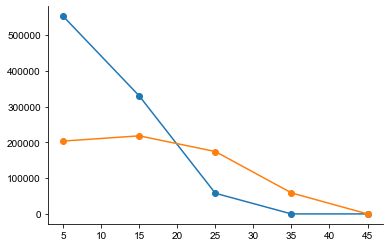

In [179]:
plt.plot(p_dist_z[:,0], nz[:,np.newaxis]*p_dist_z[:,1:], '-o')

In [140]:
def f_fit(x, mu, a, N):
    return N*np.exp(-a*(x-mu)*(x-mu))*x

p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,1], p0=[50, 0.001, 100000])
p_xy

(array([2.08043970e+01, 2.55078353e-04, 5.31416508e+03]),
 array([[ 2.56909500e+02,  1.32128475e-03, -1.27565580e+04],
        [ 1.32128475e-03,  7.68311895e-09, -5.56302819e-02],
        [-1.27565580e+04, -5.56302819e-02,  8.64233585e+05]]))

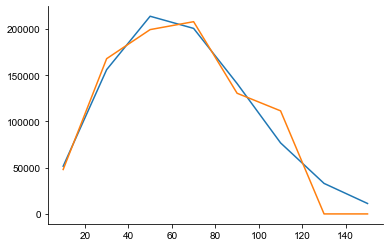

In [141]:
plt.plot(p_dist_xy[:,0], f_fit(p_dist_xy[:,0], *p_xy[0]), p_dist_xy[:,0], nxy*p_dist_xy[:,1])

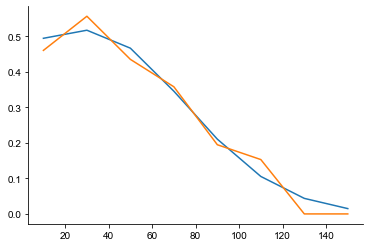

In [110]:
plt.plot(p_dist_xy[:,0], f_fit(p_dist_xy[:,0], *p[0])/nxy, p_dist_xy[:,0], p_dist_xy[:,1])

In [113]:
p = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,2], p0=[50, 0.001, 100000])
p

(array([3.31682905e+01, 1.64911617e-04, 1.93526142e+03]),
 array([[ 7.79495203e+02,  2.31589237e-03, -9.62254490e+03],
        [ 2.31589237e-03,  7.83937862e-09, -2.31815966e-02],
        [-9.62254490e+03, -2.31815966e-02,  1.81759547e+05]]))

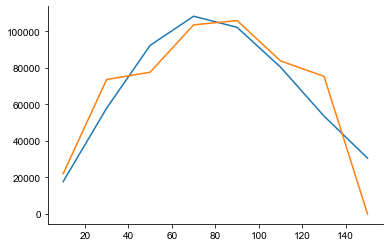

In [114]:
plt.plot(p_dist_xy[:,0], f_fit(p_dist_xy[:,0], *p[0]), p_dist_xy[:,0], nxy*p_dist_xy[:,2])

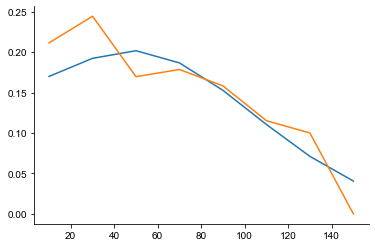

In [115]:
plt.plot(p_dist_xy[:,0], f_fit(p_dist_xy[:,0], *p[0])/nxy, p_dist_xy[:,0], p_dist_xy[:,2])

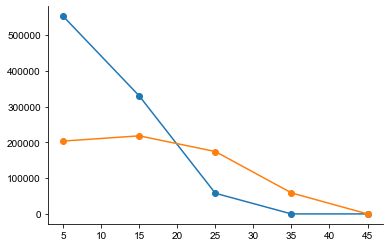

In [181]:
plt.plot(p_dist_z[:,0], nz[:,np.newaxis]*p_dist_z[:,1:], '-o')

In [189]:
def f_fit(x, mu, a, N):
    return N*np.exp(-a*(x-mu)*(x-mu))

p = curve_fit(f_fit, p_dist_z[:,0], nz*p_dist_z[:,1], p0=[10, 0.001, 100000])
p

(array([5.82232706e+00, 6.17339375e-03, 5.54723049e+05]),
 array([[2.50955716e-02, 2.81810939e-05, 6.26006004e+01],
        [2.81810939e-05, 3.61454137e-08, 1.33601418e-01],
        [6.26006004e+01, 1.33601418e-01, 4.21053168e+06]]))

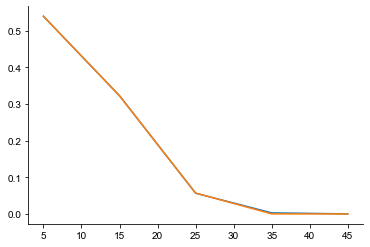

In [183]:
plt.plot(p_dist_z[:,0], f_fit(p_dist_z[:,0], *p[0])/nz, p_dist_z[:,0], p_dist_z[:,1])

In [184]:
p = curve_fit(f_fit, p_dist_z[:,0], nz*p_dist_z[:,2], p0=[10, 0.001, 100000])
p

(array([1.28960198e+01, 2.64170525e-03, 2.33702630e+05]),
 array([[2.42475978e+00, 6.17893800e-04, 5.16517292e+03],
        [6.17893800e-04, 4.24878180e-07, 5.73403608e+00],
        [5.16517292e+03, 5.73403608e+00, 2.41853612e+08]]))

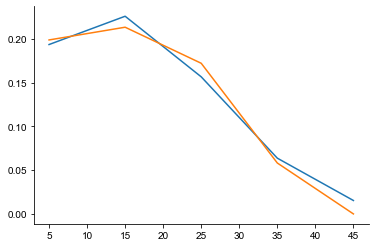

In [185]:
plt.plot(p_dist_z[:,0], f_fit(p_dist_z[:,0], *p[0])/nz, p_dist_z[:,0], p_dist_z[:,2])

In [131]:
nxy, _ = np.histogram(som_dist['dist_xy'], bins=np.arange(0, 180, 20))

In [136]:
def f_fit(x, mu, a, N):
    return N*np.exp(-a*(x-mu)*(x-mu))*x

p_pxy = curve_fit(f_fit, p_dist_xy[:,0], nxy, p0=[50, 0.001, 100000])
p_pxy

(array([-1.09634625e+02,  1.43100368e-05,  1.31777106e+04]),
 array([[ 1.85474051e+02,  1.26616089e-05, -7.12692472e+03],
        [ 1.26616089e-05,  8.70959022e-13, -4.82358393e-04],
        [-7.12692472e+03, -4.82358393e-04,  2.76726376e+05]]))

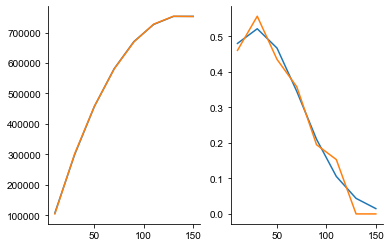

In [153]:
_, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(p_dist_xy[:,0], f_fit(p_dist_xy[:,0], *p_pxy[0]), p_dist_xy[:,0], nxy)
ax2.plot(p_dist_xy[:,0], f_fit(p_dist_xy[:,0], *p_xy[0])/f_fit(p_dist_xy[:,0], *p_pxy[0]), p_dist_xy[:,0], p_dist_xy[:,1])

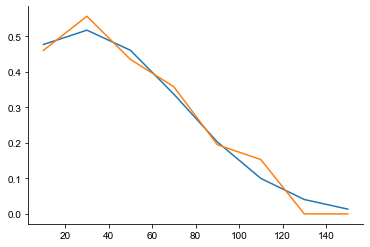

In [154]:
plt.plot(
    p_dist_xy[:,0], 
    f_fit(p_dist_xy[:,0], 20.8, 2.6e-4, 5300)/f_fit(p_dist_xy[:,0], -110, 1.4e-5, 13177), 
    p_dist_xy[:,0], 
    p_dist_xy[:,1]
)

In [162]:
p_xy = curve_fit(f_fit, p_dist_xy[:,0], nxy*p_dist_xy[:,2], p0=[50, 0.001, 100000])
p_xy

(array([3.31682905e+01, 1.64911617e-04, 1.93526142e+03]),
 array([[ 7.79495203e+02,  2.31589237e-03, -9.62254490e+03],
        [ 2.31589237e-03,  7.83937862e-09, -2.31815966e-02],
        [-9.62254490e+03, -2.31815966e-02,  1.81759547e+05]]))

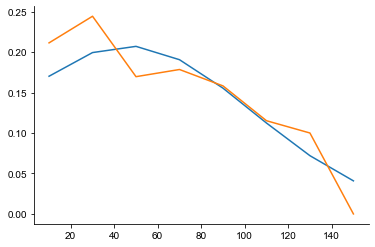

In [167]:
plt.plot(
    p_dist_xy[:,0], 
    f_fit(p_dist_xy[:,0], 33, 1.65e-4, 2000)/f_fit(p_dist_xy[:,0], -110, 1.4e-5, 13177),
    p_dist_xy[:,0], 
    p_dist_xy[:,2]
)

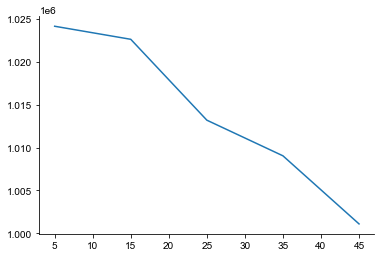

In [188]:
plt.plot(p_dist_z[:,0], nz)

In [186]:
def f_fit(x, mu, a, N):
    return N*np.exp(-a*(x-mu)*(x-mu))

p_pz = curve_fit(f_fit, p_dist_z[:,0], nz, p0=[50, 0.001, 100000])
# p_pz

/var/folders/dd/lzv3mtbd2555qjgqz9j9nbtc0000gn/T/ipykernel_25091/4103860768.py:2: RuntimeWarning: overflow encountered in exp
  return N*np.exp(-a*(x-mu)*(x-mu))


(array([-2.83748681e+01,  5.52355974e-06,  1.03121201e+06]),
 array([[ 2.86638199e+03,  2.93470696e-04, -8.20205841e+05],
        [ 2.93470696e-04,  3.04172990e-11, -8.28199287e-02],
        [-8.20205841e+05, -8.28199287e-02,  2.39207752e+08]]))

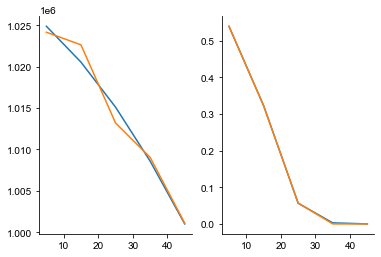

In [190]:
_, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(p_dist_z[:,0], f_fit(p_dist_z[:,0], *p_pz[0]), p_dist_z[:,0], nz)
ax2.plot(p_dist_z[:,0], f_fit(p_dist_z[:,0], *p[0])/f_fit(p_dist_z[:,0], *p_pz[0]), p_dist_z[:,0], p_dist_z[:,1])

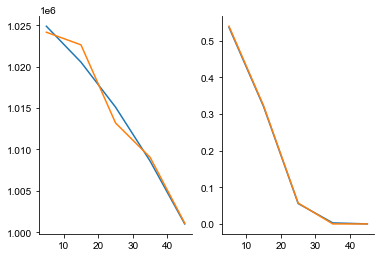

In [192]:
_, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(p_dist_z[:,0], f_fit(p_dist_z[:,0], *p_pz[0]), p_dist_z[:,0], nz)
ax2.plot(p_dist_z[:,0], f_fit(p_dist_z[:,0], *p[0])/f_fit(p_dist_z[:,0], 0, 0, 1.03e6), p_dist_z[:,0], p_dist_z[:,1])

In [196]:
p = curve_fit(f_fit, p_dist_z[:,0], nz*p_dist_z[:,1], p0=[10, 0.001, 100000])
p

(array([5.82232706e+00, 6.17339375e-03, 5.54723049e+05]),
 array([[2.50955716e-02, 2.81810939e-05, 6.26006004e+01],
        [2.81810939e-05, 3.61454137e-08, 1.33601418e-01],
        [6.26006004e+01, 1.33601418e-01, 4.21053168e+06]]))

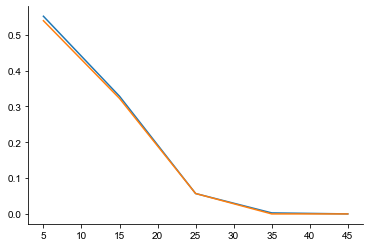

In [197]:
plt.plot(
    p_dist_z[:,0], 
    f_fit(p_dist_z[:,0], 5.8, 6.173e-3, 5.54e5)/f_fit(p_dist_z[:,0], 0, 0, 1e6), 
    p_dist_z[:,0], 
    p_dist_z[:,1]
)

In [198]:
p = curve_fit(f_fit, p_dist_z[:,0], nz*p_dist_z[:,2], p0=[10, 0.001, 100000])
p

(array([1.28960198e+01, 2.64170525e-03, 2.33702630e+05]),
 array([[2.42475978e+00, 6.17893800e-04, 5.16517292e+03],
        [6.17893800e-04, 4.24878180e-07, 5.73403608e+00],
        [5.16517292e+03, 5.73403608e+00, 2.41853612e+08]]))

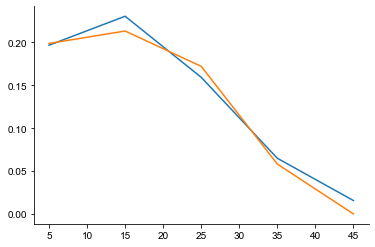

In [203]:
plt.plot(
    p_dist_z[:,0], 
    f_fit(p_dist_z[:,0], 13, 2.64e-3, 2.34e5)/f_fit(p_dist_z[:,0], 0, 0, 1e6), 
    p_dist_z[:,0], 
    p_dist_z[:,2]
)